In [ ]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=6ae390f41b824cf575ed6f1eb39ec22c7c8d9f70e55ec8b8dda58c30dcaea18f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [ ]:
file_path = './'
names = ['apple', 'disney', 'HBO', 'netflix', 'paramount', 'prime']

In [ ]:
for name in names : 
    with open(file_path+name+"_titles.csv", 'rb') as f:
        df = pd.read_csv(f)
    globals()['{}_df'.format(name)] = df

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

n_gram_range = (2, 2)
stop_words = "english"

In [ ]:
import string
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import os

file_names = ['apple_titles.csv', 'HBO_titles.csv', 'disney_titles.csv', 'netflix_titles.csv', 'paramount_titles.csv', 'prime_titles.csv']
output_directory = './wordclouds'  # 결과 저장

# 저장을 편하게 하려고 만든 디렉토리
os.makedirs(output_directory, exist_ok=True)

# 장르별로 6사 discription에 대한 워드 클라우드 생성
def generate_word_cloud(dataset_name, df):
    horror_df = df[df['genres'].str.contains('horror', case=False, na=False)]

    # western의 경우에 5사만 있어서 구분용으로 if문 생성, 혹시 모를 오타 에러에 대비해서 if 문 처리
    if horror_df.empty:
        print(f"No descriptions found for the horror genre in the {dataset_name} dataset.")
    else:
        # 문장부호는 제거함. discription에 있는 단어들을 토큰화 하여 tagged_word 에 집어넣음
        stop_words = set(stopwords.words('english'))
        punctuation = set(string.punctuation)
        sentences_tag = []
        for description in horror_df['description']:
            if pd.notnull(description):
                words = word_tokenize(description)
                words = [word.lower() for word in words if word.lower() not in punctuation]
                tagged_words = pos_tag(words)
                sentences_tag.extend(tagged_words)

        # 모든 discription에서 고질적으로 발생한 문제인 new, young의 출력을 없애기 위해 코드를 추가함, 역시나 마찬가지로 명사와 형용사에 안해서만 wordcloud 생성
        noun_adj_list = []
        for word, tag in sentences_tag:
            if tag.startswith('NN') or tag.startswith('JJ'):
                if word not in stop_words and word != 'new' and word != 'young':
                    noun_adj_list.append(word)

        # 빈도수 기준으로 출력하기 위해 빈도수 측정, 상위 40개의 단어들만 출력
        counts = FreqDist(noun_adj_list)
        tags = counts.most_common(40)

        # 워드 클라우드 만들기
        wc = WordCloud(font_path='./NanumGothicBold.otf', background_color="white", max_font_size=60)
        cloud = wc.generate_from_frequencies(dict(tags))

        # 시각화, 출력하는 그래프가 많아서 그래프 이름을 따로 적어줌
        plt.figure(figsize=(12, 10))
        plt.title(f"Word Cloud for {dataset_name} - Western Genre")
        plt.axis('off')
        plt.imshow(cloud)
        
        # wordcloud 저장
        output_file = os.path.join(output_directory, f"{dataset_name}_wordcloud_western.png")
        plt.savefig(output_file)
        plt.close()

# 총 6개 만들기
for file_name in file_names:
    dataset_name = file_name.split('.')[0]
    df = pd.read_csv(file_name)
    generate_word_cloud(dataset_name, df)

No descriptions found for the western genre in the apple_titles dataset.


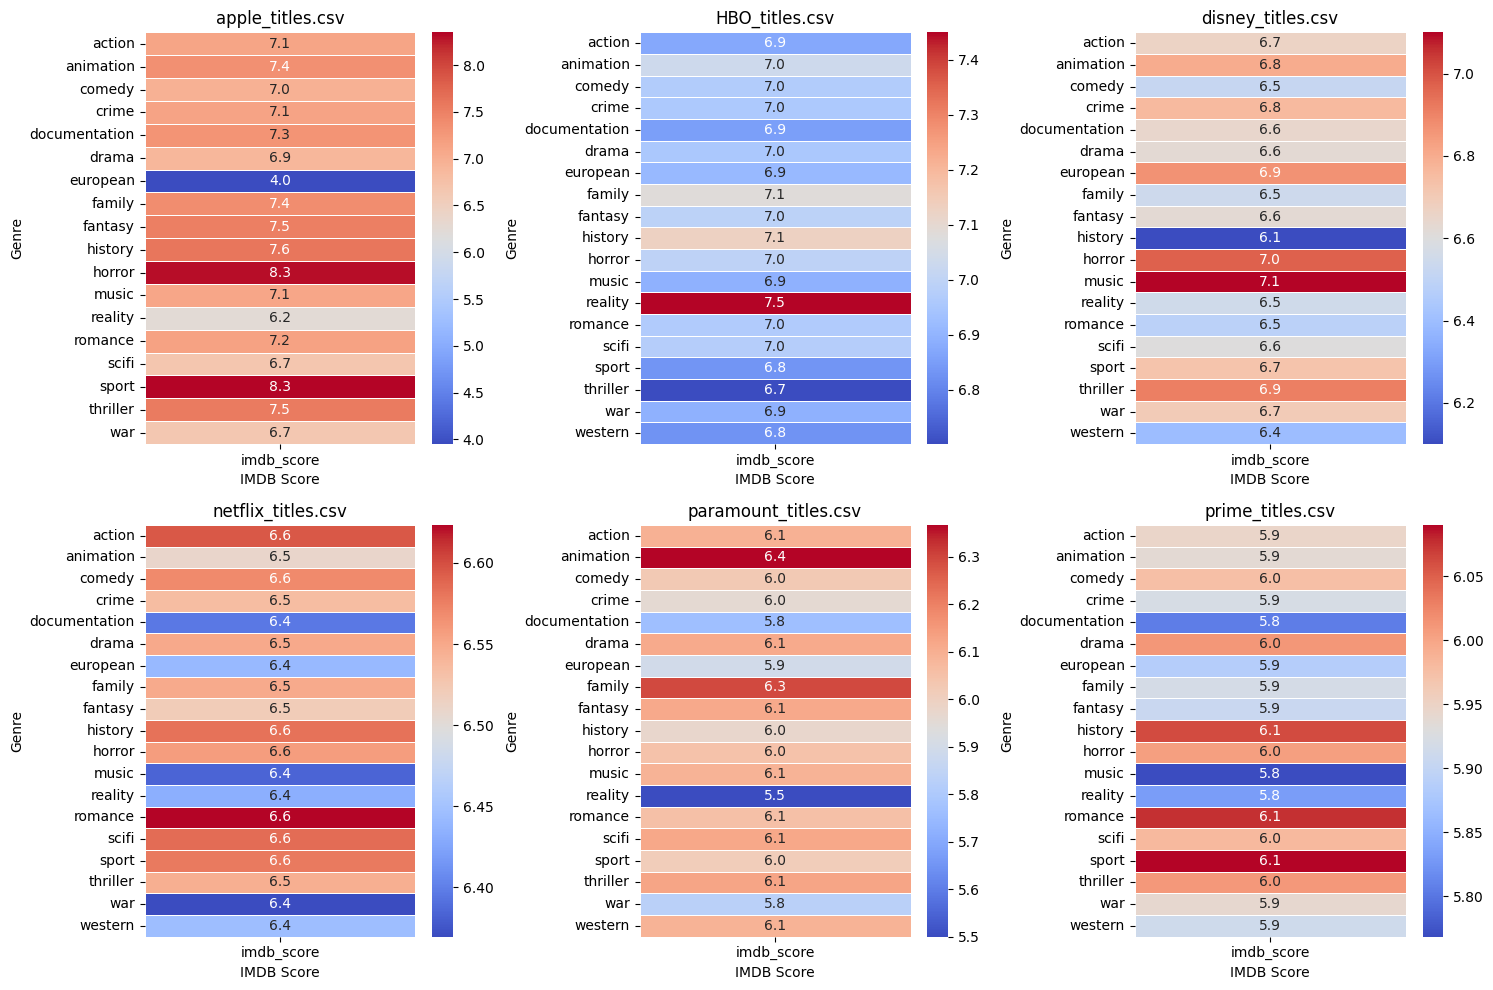

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_names = ['apple_titles.csv', 'HBO_titles.csv', 'disney_titles.csv', 'netflix_titles.csv', 'paramount_titles.csv', 'prime_titles.csv']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, (file_name, ax) in enumerate(zip(file_names, axes.flatten())):
    genre_scores = {}

    df = pd.read_csv(file_name)
    df['genres'] = df['genres'].str.replace('  ', 'Unknown')  # Replace '  ' with 'Unknown'

    genres = df['genres'].str.split(',').explode().str.strip()

    for genre, score in zip(genres, df['imdb_score']):
        genre = genre.strip("[]'")
        
        if genre != '':
            if genre != 'Unknown':
                if genre in genre_scores:
                    genre_scores[genre].append(score)
                else:
                    genre_scores[genre] = [score]

    # Remove empty genre entry
    if '' in genre_scores:
        del genre_scores['']

    df_genre_scores = pd.DataFrame({'genres': list(genre_scores.keys()), 'imdb_score': list(genre_scores.values())})
    df_genre_scores = df_genre_scores.explode('imdb_score')
    df_genre_scores['imdb_score'] = df_genre_scores['imdb_score'].astype(float)

    pivot_table = df_genre_scores.pivot_table(values='imdb_score', index='genres', aggfunc='mean')

    sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5, ax=ax)
    ax.set_title(file_name)
    ax.set_xlabel('IMDB Score')
    ax.set_ylabel('Genre')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

netflix = pd.read_csv("./netflix_titles.csv")
hbo = pd.read_csv("./HBO_titles.csv")
apple = pd.read_csv("./apple_titles.csv")
disney = pd.read_csv("./disney_titles.csv")
paramount = pd.read_csv("./paramount_titles.csv")
prime = pd.read_csv("./prime_titles.csv")

In [5]:
# netflix
# hbo
# apple
# disney
# paramount
# amazon

In [6]:
from itertools import combinations # 조합

platforms_list = ["netflix", "hbo", "apple", "disney", "paramount", "prime"]
platforms_dict = {"netflix" : netflix, 
                        "hbo" : hbo, 
                        "apple" : apple, 
                        "disney" : disney, 
                        "paramount" : paramount, 
                        "prime" : prime}

combination_platforms_2 = list(combinations(platforms_list, 2))
combination_platforms_3 = list(combinations(platforms_list, 3))
combination_platforms_4 = list(combinations(platforms_list, 4))
combination_platforms_5 = list(combinations(platforms_list, 5))


print(combination_platforms_2)
print(len(combination_platforms_2))
print(combination_platforms_3)
print(len(combination_platforms_3))
print(combination_platforms_4)
print(len(combination_platforms_4))
print(combination_platforms_5)
print(len(combination_platforms_5))


[('netflix', 'hbo'), ('netflix', 'apple'), ('netflix', 'disney'), ('netflix', 'paramount'), ('netflix', 'prime'), ('hbo', 'apple'), ('hbo', 'disney'), ('hbo', 'paramount'), ('hbo', 'prime'), ('apple', 'disney'), ('apple', 'paramount'), ('apple', 'prime'), ('disney', 'paramount'), ('disney', 'prime'), ('paramount', 'prime')]
15
[('netflix', 'hbo', 'apple'), ('netflix', 'hbo', 'disney'), ('netflix', 'hbo', 'paramount'), ('netflix', 'hbo', 'prime'), ('netflix', 'apple', 'disney'), ('netflix', 'apple', 'paramount'), ('netflix', 'apple', 'prime'), ('netflix', 'disney', 'paramount'), ('netflix', 'disney', 'prime'), ('netflix', 'paramount', 'prime'), ('hbo', 'apple', 'disney'), ('hbo', 'apple', 'paramount'), ('hbo', 'apple', 'prime'), ('hbo', 'disney', 'paramount'), ('hbo', 'disney', 'prime'), ('hbo', 'paramount', 'prime'), ('apple', 'disney', 'paramount'), ('apple', 'disney', 'prime'), ('apple', 'paramount', 'prime'), ('disney', 'paramount', 'prime')]
20
[('netflix', 'hbo', 'apple', 'disney'

In [7]:
merged_df_dict_2 = {}

for index, pf in enumerate(combination_platforms_2): # pf: platform 2개가 들어있는 튜플
    merged_df_name = f"merged_df_{index+1}"
    print(f"index: {index+1}, pf: {pf}")
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    
    df_is_same = merged_df['id_x'] == merged_df['id_y']
    
    
    if True not in df_is_same.value_counts() and False not in df_is_same.value_counts():
        merged_df_dict_2[merged_df_name] = (0, 0)
    
    elif True not in df_is_same.value_counts():
        merged_df_dict_2[merged_df_name] = (0, df_is_same.value_counts()[False])

        # 
    elif False not in df_is_same.value_counts():
        merged_df_dict_2[merged_df_name] = (df_is_same.value_counts()[True], 0)

    else:
        merged_df_dict_2[merged_df_name] = (df_is_same.value_counts()[True], df_is_same.value_counts()[False])

index: 1, pf: ('netflix', 'hbo')
index: 2, pf: ('netflix', 'apple')
index: 3, pf: ('netflix', 'disney')
index: 4, pf: ('netflix', 'paramount')
index: 5, pf: ('netflix', 'prime')
index: 6, pf: ('hbo', 'apple')
index: 7, pf: ('hbo', 'disney')
index: 8, pf: ('hbo', 'paramount')
index: 9, pf: ('hbo', 'prime')
index: 10, pf: ('apple', 'disney')
index: 11, pf: ('apple', 'paramount')
index: 12, pf: ('apple', 'prime')
index: 13, pf: ('disney', 'paramount')
index: 14, pf: ('disney', 'prime')
index: 15, pf: ('paramount', 'prime')


In [8]:
for key, value in merged_df_dict_2.items():
    print(f"{key} 비교 결과-> \t true num: {value[0]}\t false num: {value[1]}")

merged_df_1 비교 결과-> 	 true num: 9	 false num: 43
merged_df_2 비교 결과-> 	 true num: 0	 false num: 1
merged_df_3 비교 결과-> 	 true num: 5	 false num: 8
merged_df_4 비교 결과-> 	 true num: 74	 false num: 44
merged_df_5 비교 결과-> 	 true num: 147	 false num: 131
merged_df_6 비교 결과-> 	 true num: 0	 false num: 2
merged_df_7 비교 결과-> 	 true num: 4	 false num: 11
merged_df_8 비교 결과-> 	 true num: 16	 false num: 27
merged_df_9 비교 결과-> 	 true num: 31	 false num: 74
merged_df_10 비교 결과-> 	 true num: 0	 false num: 0
merged_df_11 비교 결과-> 	 true num: 1	 false num: 3
merged_df_12 비교 결과-> 	 true num: 0	 false num: 3
merged_df_13 비교 결과-> 	 true num: 4	 false num: 15
merged_df_14 비교 결과-> 	 true num: 8	 false num: 47
merged_df_15 비교 결과-> 	 true num: 1609	 false num: 107


In [9]:
merged_df_dict_para = {}

for index, pf in enumerate(combination_platforms_2): # pf: platform 2개가 들어있는 튜플
    if "paramount" in pf:
        merged_df_name = f"merged_df_{index+1}"
        print(f"index: {index+1}, pf: {pf}")
        merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")

        df_is_same = merged_df['id_x'] == merged_df['id_y']

        if True not in df_is_same.value_counts() and False not in df_is_same.value_counts():
            merged_df_dict_para[merged_df_name] = (0, 0)

        elif True not in df_is_same.value_counts():
            merged_df_dict_para[merged_df_name] = (0, df_is_same.value_counts()[False])

        elif False not in df_is_same.value_counts():
            merged_df_dict_para[merged_df_name] = (df_is_same.value_counts()[True], 0)

        else:
            merged_df_dict_para[merged_df_name] = (df_is_same.value_counts()[True], df_is_same.value_counts()[False])

index: 4, pf: ('netflix', 'paramount')
index: 8, pf: ('hbo', 'paramount')
index: 11, pf: ('apple', 'paramount')
index: 13, pf: ('disney', 'paramount')
index: 15, pf: ('paramount', 'prime')


In [10]:
merged_df_dict_prime = {}

for index, pf in enumerate(combination_platforms_2): # pf: platform 2개가 들어있는 튜플
    if "prime" in pf:
        merged_df_name = f"merged_df_{index+1}"
        print(f"index: {index+1}, pf: {pf}")
        merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")

        df_is_same = merged_df['id_x'] == merged_df['id_y']

        if True not in df_is_same.value_counts() and False not in df_is_same.value_counts():
            merged_df_dict_prime[merged_df_name] = (0, 0)

        elif True not in df_is_same.value_counts():
            merged_df_dict_prime[merged_df_name] = (0, df_is_same.value_counts()[False])

        elif False not in df_is_same.value_counts():
            merged_df_dict_prime[merged_df_name] = (df_is_same.value_counts()[True], 0)

        else:
            merged_df_dict_prime[merged_df_name] = (df_is_same.value_counts()[True], df_is_same.value_counts()[False])

index: 5, pf: ('netflix', 'prime')
index: 9, pf: ('hbo', 'prime')
index: 12, pf: ('apple', 'prime')
index: 14, pf: ('disney', 'prime')
index: 15, pf: ('paramount', 'prime')


In [11]:
all_dup = 0
non_duplicate_ids = []

for key, value in merged_df_dict_para.items():
    print(f"{key} para 비교 결과-> \t true num: {value[0]}\t false num: {value[1]}")
    all_dup += value[0]

    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_ids.extend(merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'id_x'])

print(f"전체 paramount가 겹치는 영화의 개수 -> \t {all_dup}")
print(f"겹치지 않는 영화의 ID -> {non_duplicate_ids}")

merged_df_4 para 비교 결과-> 	 true num: 74	 false num: 44
merged_df_8 para 비교 결과-> 	 true num: 16	 false num: 27
merged_df_11 para 비교 결과-> 	 true num: 1	 false num: 3
merged_df_13 para 비교 결과-> 	 true num: 4	 false num: 15
merged_df_15 para 비교 결과-> 	 true num: 1609	 false num: 107
전체 paramount가 겹치는 영화의 개수 -> 	 1704
겹치지 않는 영화의 ID -> ['tm19424', 'tm140761', 'tm140761', 'tm91623', 'tm98294', 'tm35201', 'tm101294', 'tm67097', 'tm96331', 'tm130467', 'tm83465', 'tm110887', 'tm75894', 'tm75894', 'tm85407', 'tm70213', 'tm66674', 'tm797344', 'tm82169', 'tm1962', 'tm80680', 'tm83003', 'tm181452', 'tm53377', 'tm73350', 'tm90190', 'tm122108', 'tm875741', 'tm91719', 'tm82291', 'tm405214', 'tm25088', 'tm132406', 'tm119374', 'tm41521', 'tm123860', 'tm65961', 'ts6236', 'ts6236', 'tm12220', 'tm17954', 'tm105061', 'tm63814', 'tm191016', 'tm188980', 'tm125210', 'tm125210', 'tm135651', 'tm135651', 'tm109828', 'tm106888', 'tm422931', 'tm22515', 'tm103390', 'tm172656', 'tm38389', 'tm58493', 'tm115357', 'tm11535

In [12]:
all_dup = 0
non_duplicate_ids = []

for key, value in merged_df_dict_prime.items():
    print(f"{key} para 비교 결과-> \t true num: {value[0]}\t false num: {value[1]}")
    all_dup += value[0]

    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_ids.extend(merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'id_x'])

print(f"전체 prime이 겹치는 영화의 개수 -> \t {all_dup}")
print(f"겹치지 않는 영화의 ID -> {non_duplicate_ids}")

merged_df_5 para 비교 결과-> 	 true num: 147	 false num: 131
merged_df_9 para 비교 결과-> 	 true num: 31	 false num: 74
merged_df_12 para 비교 결과-> 	 true num: 0	 false num: 3
merged_df_14 para 비교 결과-> 	 true num: 8	 false num: 47
merged_df_15 para 비교 결과-> 	 true num: 1609	 false num: 107
전체 prime이 겹치는 영화의 개수 -> 	 1795
겹치지 않는 영화의 ID -> ['tm19424', 'tm140761', 'tm140761', 'tm91623', 'tm98294', 'tm35201', 'tm101294', 'tm67097', 'tm96331', 'tm130467', 'tm83465', 'tm110887', 'tm75894', 'tm75894', 'tm85407', 'tm70213', 'tm66674', 'tm797344', 'tm82169', 'tm1962', 'tm80680', 'tm83003', 'tm181452', 'tm53377', 'tm73350', 'tm90190', 'tm122108', 'tm875741', 'tm91719', 'tm82291', 'tm405214', 'tm25088', 'tm132406', 'tm119374', 'tm41521', 'tm123860', 'tm65961', 'ts6236', 'ts6236', 'tm12220', 'tm17954', 'tm105061', 'tm63814', 'tm191016', 'tm188980', 'tm125210', 'tm125210', 'tm135651', 'tm135651', 'tm109828', 'tm106888', 'tm422931', 'tm22515', 'tm103390', 'tm172656', 'tm38389', 'tm58493', 'tm115357', 'tm115357'

In [13]:
paramount = pd.read_csv("./paramount_titles.csv")

para_only_genres = []

for key, value in merged_df_dict_para.items():
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_movies = merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'title']
    
    # 겹치지 않는 영화 데이터에서 장르 추출
    for movie_title in non_duplicate_movies:
        if movie_title in paramount['title'].values:
            movie_data = paramount[paramount['title'] == movie_title]
            genre = movie_data['genres'].values[0]  # 장르 추출
            para_only_genres.append(genre)

# 추출된 장르 출력
print("추출된 장르:")
print(para_only_genres)

추출된 장르:
["['drama', 'thriller', 'crime']", "['drama', 'thriller', 'fantasy', 'scifi']", "['drama', 'thriller', 'fantasy', 'scifi']", "['crime']", "['horror', 'scifi']", "['comedy', 'romance']", "['drama', 'romance', 'crime']", "['drama', 'thriller', 'crime']", "['music', 'comedy']", "['drama', 'romance', 'comedy']", "['romance', 'music']", "['western', 'music', 'action']", "['comedy', 'drama']", "['comedy', 'drama']", "['drama']", "['drama']", "['drama', 'crime']", "['western']", "['drama', 'sport']", "['drama', 'crime']", "['drama', 'thriller']", "['horror', 'thriller']", "['horror', 'thriller']", "['western', 'drama', 'action']", "['western', 'drama']", "['western', 'drama']", "['romance', 'music', 'comedy']", "['romance', 'music', 'comedy']", "['documentation', 'war']", "['drama', 'romance']", "['comedy', 'documentation']", "['thriller', 'scifi', 'action', 'crime']", "['action', 'thriller', 'drama', 'crime']", "['drama', 'comedy']", "['thriller']", "['comedy', 'romance']", "['drama'

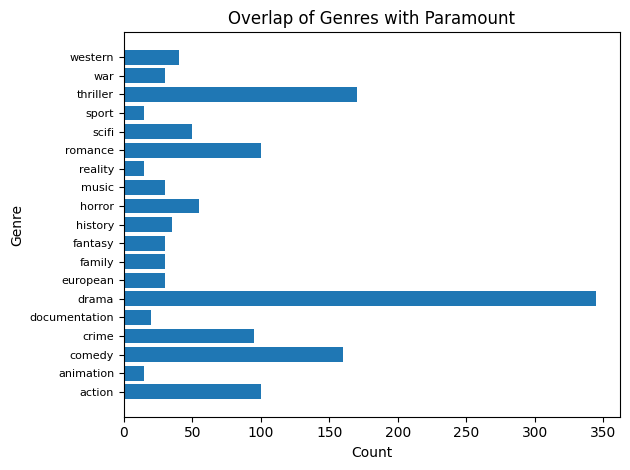

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

paramount = pd.read_csv("./paramount_titles.csv")

genre_counts = {}

for key, value in merged_df_dict_para.items():
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_movies = merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'title']

    # 겹치지 않는 영화 데이터에서 장르 추출
    for movie_title in non_duplicate_movies:
        if movie_title in paramount['title'].values:
            movie_data = paramount[paramount['title'] == movie_title]
            genres = movie_data['genres'].values[0]  # 장르 추출

            # 각 장르를 원소별로 분리하고 처리
            genre_list = genres.strip("[]").replace("'", "").split(", ")
            for genre in genre_list:
                genre = genre.strip()

                if genre != '':
                    if genre != 'Unknown':
                        if genre in genre_counts:
                            genre_counts[genre] += 1
                        else:
                            genre_counts[genre] = 1

# ' ' 행 제거
if '' in genre_counts:
    del genre_counts['']

df_genre_counts = pd.DataFrame({'Genre': list(genre_counts.keys()), 'Count': list(genre_counts.values())})
df_genre_counts = df_genre_counts.sort_values('Genre')  # 사전순으로 정렬

plt.barh(df_genre_counts['Genre'], df_genre_counts['Count'])
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Overlap of Genres with Paramount')
plt.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

In [15]:
#thriller가 유독 독점 비율이 많큼.  드라마는 900개 가까이 줄었어 기문에 못 미더움 thriller 별점만 따로 찍어보고싶다
#전체 안겹치는 영화 평점 가져와 보자
#안겹치는 영화 워드 클라우드 만들어보자. 독점작이 어떤게 있다! << 이거

In [30]:
import statistics
import pandas as pd
import numpy as np
import math

paramount = pd.read_csv("./paramount_titles.csv")

para_only_imdb = []

for key, value in merged_df_dict_para.items():
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_movies = merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'title']
    
    # 겹치지 않는 영화 데이터에서 장르 추출
    for movie_title in non_duplicate_movies:
        if movie_title in paramount['title'].values:
            movie_data = paramount[paramount['title'] == movie_title]
            imdb = movie_data['imdb_score'].values[0]  # 장르 추출
            para_only_imdb.append(imdb)

# 추출된 장르 출력
print("추출된 점수:")
print(para_only_imdb)

newlist = [x for x in para_only_imdb if math.isnan(x) == False]

print (statistics.mean(newlist))

print(len(para_only_imdb))

추출된 점수:
[7.3, 7.0, 7.0, 6.8, 3.7, 5.5, 5.5, 5.6, nan, 6.2, 5.4, 6.2, 5.6, 5.6, 6.6, 5.6, 5.5, 5.5, 8.1, 9.0, 7.9, 7.4, 7.4, 7.7, 7.4, 7.4, 7.0, 7.0, 7.5, 6.3, 5.8, 7.6, 6.6, 6.9, 4.0, 5.6, 6.9, 5.5, 5.5, 4.3, 6.4, 6.8, 5.2, 7.0, 6.2, 6.6, 6.6, 6.6, 6.6, 3.0, 6.9, 5.9, 5.7, 6.4, 6.0, 6.4, 4.6, 6.3, 6.3, 6.8, 6.7, 6.5, nan, 7.9, nan, nan, 6.9, 7.0, 6.0, 3.2, 5.2, 6.1, 6.1, 3.5, 4.7, 3.8, 3.8, 7.1, 6.2, 6.2, 5.5, 6.5, 7.3, 6.6, 7.7, 6.6, 5.5, 5.6, 6.1, 5.2, 4.5, 6.6, 4.8, 3.5, 7.6, 6.7, 6.2, 6.3, 7.3, 5.8, 5.0, 5.3, 7.3, 5.9, 4.2, nan, nan, 7.3, 7.0, 7.0, 6.8, 3.7, 5.5, 5.5, 5.6, nan, 6.2, 5.4, 6.2, 5.6, 5.6, 6.6, 5.6, 5.5, 5.5, 8.1, 9.0, 7.9, 7.4, 7.4, 7.7, 7.4, 7.4, 7.0, 7.0, 7.5, 6.3, 5.8, 7.6, 6.6, 6.9, 4.0, 5.6, 6.9, 5.5, 5.5, 4.3, 6.4, 6.8, 5.2, 7.0, 6.2, 6.6, 6.6, 6.6, 6.6, 3.0, 6.9, 5.9, 5.7, 6.4, 6.0, 6.4, 4.6, 6.3, 6.3, 6.8, 6.7, 6.5, nan, 7.9, nan, nan, 6.9, 7.0, 6.0, 3.2, 5.2, 6.1, 6.1, 3.5, 4.7, 3.8, 3.8, 7.1, 6.2, 6.2, 5.5, 6.5, 7.3, 6.6, 7.7, 6.6, 5.5, 5.6, 6.1, 5.2, 4.5, 6

In [35]:
newlist = [x for x in para_only_imdb if math.isnan(x) == False]
print (statistics.mean(newlist))
print(statistics.median(newlist))
print(statistics.variance(newlist))

file_names = ['paramount_titles.csv']


# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

df.dropna(subset=['imdb_score'])
mean_all_para = df['imdb_score'].mean()

median_all_para = df['imdb_score'].median()
var_all_para = df['imdb_score'].var()

print()

print(mean_all_para)
print(median_all_para)
print(var_all_para)

6.120792079207921
6.3
1.3274438158101525

6.067159663865546
6.1
1.629953429441716


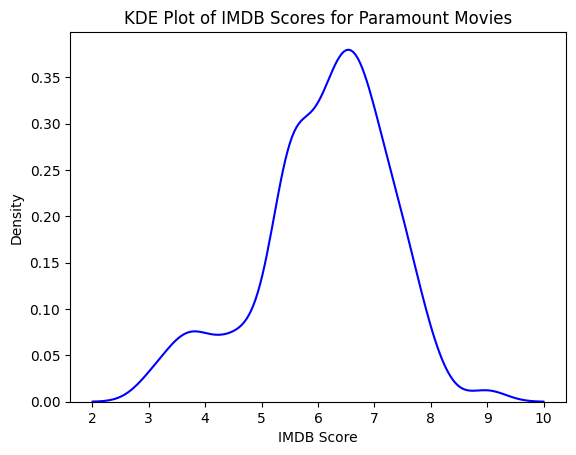

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# KDE 플롯 그리기
sns.kdeplot(para_only_imdb, color='blue')

# 축 및 제목 설정
plt.xlabel('IMDB Score')
plt.ylabel('Density')
plt.title('KDE Plot of IMDB Scores for Paramount Movies')

# 그래프 출력
plt.show()

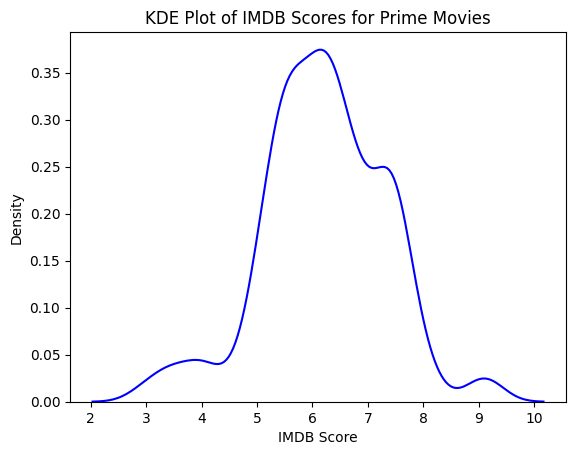

In [18]:
prime = pd.read_csv("./prime_titles.csv")

prime_only_imdb = []

for key, value in merged_df_dict_para.items():
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_movies = merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'title']
    
    # 겹치지 않는 영화 데이터에서 장르 추출
    for movie_title in non_duplicate_movies:
        if movie_title in prime['title'].values:
            movie_data = prime[prime['title'] == movie_title]
            imdb = movie_data['imdb_score'].values[0]  # 장르 추출
            prime_only_imdb.append(imdb)

# KDE 플롯 그리기
sns.kdeplot(prime_only_imdb, color='blue')

# 축 및 제목 설정
plt.xlabel('IMDB Score')
plt.ylabel('Density')
plt.title('KDE Plot of IMDB Scores for Prime Movies')

# 그래프 출력
plt.show()

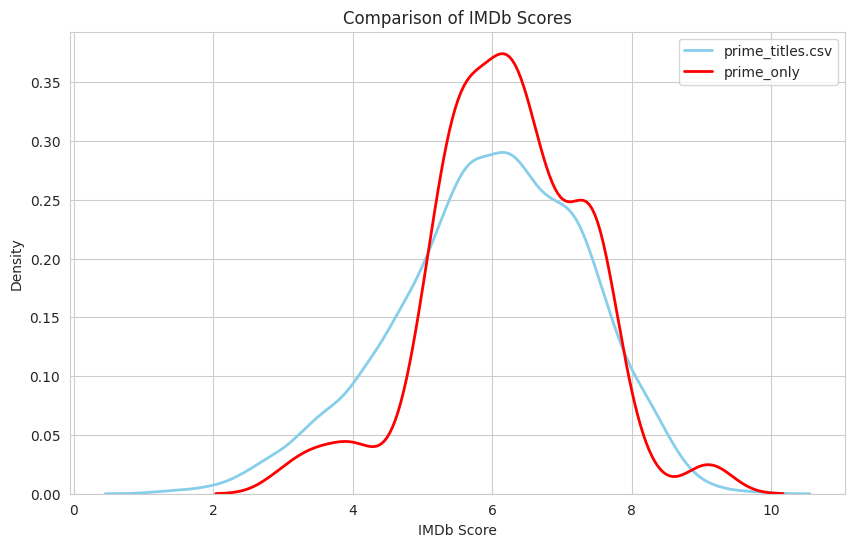

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일명 리스트
file_names = ['prime_titles.csv']

# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

# 플롯 스타일 설정
sns.set_palette("husl")  # 색상 팔레트 설정
sns.set_style("whitegrid")  # 배경 그리드 스타일 설정

# IMDb 점수를 기준으로 KDE plot 그리기
plt.figure(figsize=(10, 6))  # 플롯 크기 조정
for i, df in enumerate(dataframes):
    sns.kdeplot(data=df['imdb_score'], color = 'skyblue', label=file_names[i], alpha=1.0, linewidth=2)

# para_only_imdb 값을 빨간색 선으로 추가
sns.kdeplot(prime_only_imdb, color='red', label='prime_only', linewidth=2)

plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.title('Comparison of IMDb Scores')
plt.legend()
plt.show()

In [36]:
newlist = [x for x in prime_only_imdb if math.isnan(x) == False]
print (statistics.mean(newlist))
print(statistics.median(newlist))
print(statistics.variance(newlist))

file_names = ['prime_titles.csv']


# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

df.dropna(subset=['imdb_score'])
mean_all_prime = df['imdb_score'].mean()
median_all_prime = df['imdb_score'].median()
var_all_prime = df['imdb_score'].var()
print()
print(mean_all_prime)
print(median_all_prime)
print(var_all_prime)



6.20625
6.2
1.2262656576200417

5.970558115719407
6.1
1.857266023993172


In [ ]:
newlist = [x for x in para_only_imdb if math.isnan(x) == False]
print (statistics.mean(newlist))
print(statistics.median(newlist))
print(statistics.variance(newlist))

file_names = ['paramount_titles.csv']


# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

df.dropna(subset=['imdb_score'])
mean_all_para = df['imdb_score'].mean()

median_all_para = df['imdb_score'].median()
var_all_para = df['imdb_score'].var()

print()

print(mean_all_para)
print(median_all_para)
print(var_all_para)


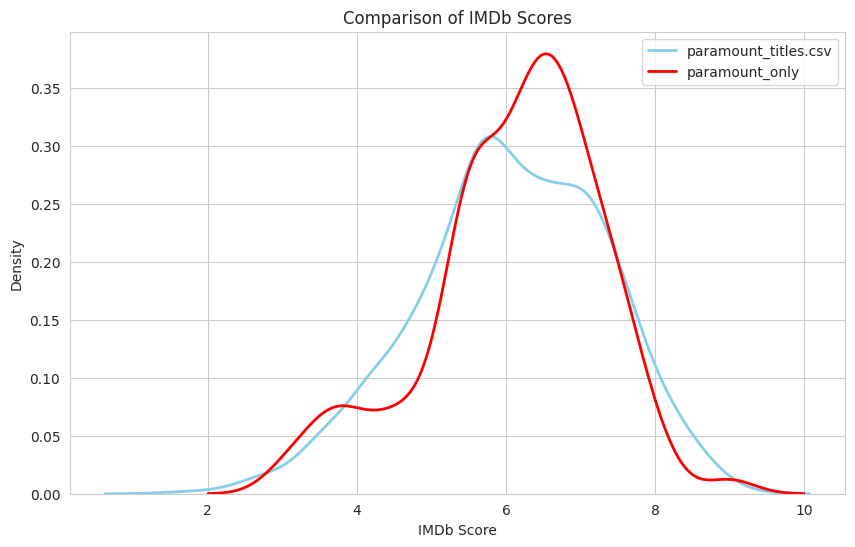

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일명 리스트
file_names = ['paramount_titles.csv']

# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

# 플롯 스타일 설정
sns.set_palette("husl")  # 색상 팔레트 설정
sns.set_style("whitegrid")  # 배경 그리드 스타일 설정

# IMDb 점수를 기준으로 KDE plot 그리기
plt.figure(figsize=(10, 6))  # 플롯 크기 조정
for i, df in enumerate(dataframes):
    sns.kdeplot(data=df['imdb_score'], color = 'skyblue', label=file_names[i], alpha=1.0, linewidth=2)

# para_only_imdb 값을 빨간색 선으로 추가
sns.kdeplot(para_only_imdb, color='red', label='paramount_only', linewidth=2)

plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.title('Comparison of IMDb Scores')
plt.legend()
plt.show()

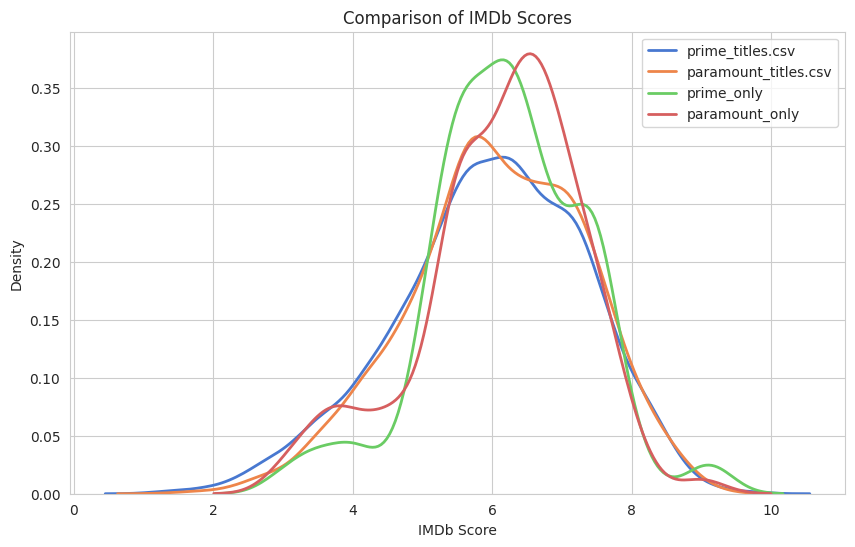

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일명 리스트
file_names = ['prime_titles.csv', 'paramount_titles.csv']

# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

# 플롯 스타일 설정
sns.set_palette("muted")  # 색상 팔레트 설정
sns.set_style("whitegrid")  # 배경 그리드 스타일 설정

# IMDb 점수를 기준으로 KDE plot 그리기
plt.figure(figsize=(10, 6))  # 플롯 크기 조정
for i, df in enumerate(dataframes):
    sns.kdeplot(data=df['imdb_score'], label=file_names[i], alpha=1.0, linewidth=2)

# para_only_imdb 값을 빨간색 선으로 추가
sns.kdeplot(prime_only_imdb, label='prime_only', linewidth=2)
sns.kdeplot(para_only_imdb,label='paramount_only', linewidth=2)

plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.title('Comparison of IMDb Scores')
plt.legend()
plt.show()

In [ ]:
paramount = pd.read_csv("./paramount_titles.csv")

para_only_type = []

for key, value in merged_df_dict_para.items():
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_movies = merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'title']
    
    # 겹치지 않는 영화 데이터에서 장르 추출
    for movie_title in non_duplicate_movies:
        if movie_title in paramount['title'].values:
            movie_data = paramount[paramount['title'] == movie_title]
            movie_type = movie_data['type'].values[0]  # 장르 추출
            para_only_type.append(str(movie_type))

type_counts = {}

for movie_type in para_only_type:
    if movie_type in type_counts:
        type_counts[movie_type] += 1
    else:
        type_counts[movie_type] = 1

# 결과 출력
for movie_type, count in type_counts.items():
    print(f"{movie_type}: {count}")

MOVIE: 475
SHOW: 60


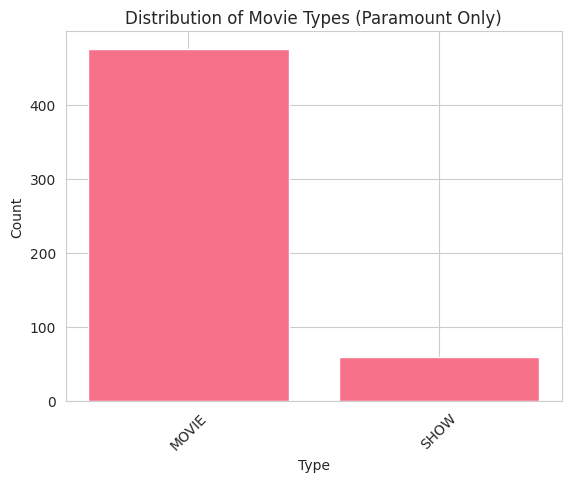

In [ ]:
labels = list(type_counts.keys())
counts = list(type_counts.values())

plt.bar(labels, counts)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of Movie Types (Paramount Only)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일명 리스트
file_names = ['prime_titles.csv']

# 데이터프레임 생성 및 IMDb 점수 컬럼 로드
dataframes = []
for file_name in file_names:
    df = pd.read_csv(file_name)
    dataframes.append(df)

# 플롯 스타일 설정
sns.set_palette("husl")  # 색상 팔레트 설정
sns.set_style("whitegrid")  # 배경 그리드 스타일 설정

# IMDb 점수를 기준으로 KDE plot 그리기
plt.figure(figsize=(10, 6))  # 플롯 크기 조정
for i, df in enumerate(dataframes):
    sns.kdeplot(data=df['imdb_score'], color = 'skyblue', label=file_names[i], alpha=1.0, linewidth=2)

# para_only_imdb 값을 빨간색 선으로 추가
sns.kdeplot(prime_only_imdb, color='red', label='prime_only', linewidth=2)

plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.title('Comparison of IMDb Scores')
plt.legend()
plt.show()

In [ ]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

disney = pd.read_csv('disney_titles.csv')

# 다운로드한 불용어 리스트를 가져옵니다
stop_words = set(stopwords.words('english'))

sentences_tag = []
for description in disney['description']:
    if pd.isnull(description):  # NaN 값 처리
        continue
    words = word_tokenize(description)
    tagged_words = pos_tag(words)
    sentences_tag.extend(tagged_words)

# Filter and collect noun and adjective words, while removing stop words
noun_adj_list = []
for word, tag in sentences_tag:
    if tag.startswith('NN') or tag.startswith('JJ'):
        word = word.lower()
        if word not in stop_words:  # 불용어 제거
            noun_adj_list.append(word)

# Count the frequencies
counts = FreqDist(noun_adj_list)
tags = counts.most_common(40)

# Generate the word cloud
wc = WordCloud(font_path='./NanumGothicBold.otf', background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(dict(tags))

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [ ]:
import pandas as pd

# 파일 이름 리스트
file_names = ['paramount_titles.csv', 'prime_titles.csv']

id_all = []

paramount_data = pd.read_csv('paramount_titles.csv')
prime_data = pd.read_csv('prime_titles.csv')

paramount_id = []
prime_id = []
    
    # ID 컬럼을 추출하여 집합에 추가합니다
for file_id in paramount_data['id']:
    paramount_id .append(file_id)

for file_id in prime_data['id']:
    prime_id.append(file_id)

all_id = paramount_id + prime_id
id_set = set(all_id)

# 겹치는 ID의 수를 계산합니다
pri_para_dup = len(all_id) - len(id_set)

# 결과를 출력합니다
print(f"겹치는 ID의 수: {pri_para_dup}")

겹치는 ID의 수: 1609


In [ ]:
import pandas as pd

# 파일 이름 리스트
file_names = ['paramount_titles.csv', 'apple_titles.csv']

id_all = []

paramount_data = pd.read_csv('paramount_titles.csv')
prime_data = pd.read_csv('apple_titles.csv')

paramount_id = []
prime_id = []
    
    # ID 컬럼을 추출하여 집합에 추가합니다
for file_id in paramount_data['id']:
    paramount_id .append(file_id)

for file_id in prime_data['id']:
    prime_id.append(file_id)

all_id = paramount_id + prime_id
id_set = set(all_id)

# 겹치는 ID의 수를 계산합니다
a_p_dup = len(all_id) - len(id_set)

# 결과를 출력합니다
print(f"겹치는 ID의 수: {a_p_dup}")

겹치는 ID의 수: 1


In [ ]:
import pandas as pd

# 파일 이름 리스트
file_names = ['paramount_titles.csv', 'HBO_titles.csv']

id_all = []

paramount_data = pd.read_csv('paramount_titles.csv')
prime_data = pd.read_csv('HBO_titles.csv')

paramount_id = []
prime_id = []
    
    # ID 컬럼을 추출하여 집합에 추가합니다
for file_id in paramount_data['id']:
    paramount_id .append(file_id)

for file_id in prime_data['id']:
    prime_id.append(file_id)

all_id = paramount_id + prime_id
id_set = set(all_id)

# 겹치는 ID의 수를 계산합니다
h_p_dup = len(all_id) - len(id_set)

# 결과를 출력합니다
print(f"겹치는 ID의 수: {h_p_dup}")

겹치는 ID의 수: 16


In [ ]:
import pandas as pd

# 파일 이름 리스트
file_names = ['paramount_titles.csv', 'disney_titles.csv']

id_all = []

paramount_data = pd.read_csv('paramount_titles.csv')
prime_data = pd.read_csv('disney_titles.csv')

paramount_id = []
prime_id = []
    
    # ID 컬럼을 추출하여 집합에 추가합니다
for file_id in paramount_data['id']:
    paramount_id .append(file_id)

for file_id in prime_data['id']:
    prime_id.append(file_id)

all_id = paramount_id + prime_id
id_set = set(all_id)

# 겹치는 ID의 수를 계산합니다
d_p_dup = len(all_id) - len(id_set)

# 결과를 출력합니다
print(f"겹치는 ID의 수: {d_p_dup}")

겹치는 ID의 수: 4


In [ ]:
import pandas as pd

# 파일 이름 리스트
file_names = ['paramount_titles.csv', 'netflix_titles.csv']

id_all = []

paramount_data = pd.read_csv('paramount_titles.csv')
prime_data = pd.read_csv('netflix_titles.csv')

paramount_id = []
prime_id = []
    
    # ID 컬럼을 추출하여 집합에 추가합니다
for file_id in paramount_data['id']:
    paramount_id .append(file_id)

for file_id in prime_data['id']:
    prime_id.append(file_id)

all_id = paramount_id + prime_id
id_set = set(all_id)

# 겹치는 ID의 수를 계산합니다
n_p_dup = len(all_id) - len(id_set)

# 결과를 출력합니다
print(f"겹치는 ID의 수: {n_p_dup}")

겹치는 ID의 수: 74


In [ ]:
all_para_dup = pri_para_dup + a_p_dup + h_p_dup + d_p_dup + n_p_dup
para_items = len(paramount_id)

rest = para_items - all_para_dup

print(f"전체와 파라마운트 사이의 겹치는 ID 수: {all_para_dup}")
print(f"파라마운트 독점 작들 개수: {rest}")

전체와 파라마운트 사이의 겹치는 ID 수: 1704
파라마운트 독점 작들 개수: 1478


In [ ]:
paramount = pd.read_csv("./paramount_titles.csv")

para_only_genres = []

for key, value in merged_df_dict_para.items():
    merged_df = pd.merge(platforms_dict[pf[0]], platforms_dict[pf[1]], on="title")
    non_duplicate_movies = merged_df.loc[merged_df['id_x'] != merged_df['id_y'], 'title']
    
    # 겹치지 않는 영화 데이터에서 장르 추출
    for movie_title in non_duplicate_movies:
        if movie_title in paramount['title'].values:
            movie_data = paramount[paramount['title'] == movie_title]
            genre = movie_data['genres'].values[0]  # 장르 추출
            para_only_genres.append(genre)

# 추출된 장르 출력
print("추출된 장르:")
for para_only_genres in para_only_genres:
    print(para_only_genres)